In [1]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import reshape as t_reshape

from matplotlib import pyplot as plt

import h5py
import numpy as np
from pathlib import Path

import tempfile
import urllib.request
import tarfile

import pickle

# Класс HDF5 Dataset для PyTorch

In [2]:
cifar10_url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

### Загружаем набор данных в виде файла tar.gz

In [3]:
def get_file_from_url(url_name, file_name, read_size=1024):
    with urllib.request.urlopen(url_name) as web_handle:
        with open(file=file_name, mode='wb') as target_file:
            while True:
                data = web_handle.read(read_size)
                if len(data) == 0:
                    break
                target_file.write(data)

In [4]:
cifar_targz_file = 'cifar10_raw.tar.gz'

In [5]:
get_file_from_url(cifar10_url, cifar_targz_file)

In [6]:
# Источник: https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        labeled_data = pickle.load(fo, encoding='bytes')
    return labeled_data

### Распаковывем содержимое архива и сохраняем в файл hdf5

In [7]:
def extract_cifar10_to_hdf5(targz_name, h5_name):
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []
    with tarfile.open(targz_name, 'r:gz') as tar:
        # распаковываем файлы архива, имеющие в названии '_batch'
        for tarinfo in tar:            
            if tarinfo.isreg() and '_batch' in tarinfo.name:
                print(f'Extracting {tarinfo.name} file...')
            else:
                continue
            with tempfile.TemporaryDirectory() as temp_dir:
                tar.extract(tarinfo, Path(temp_dir))
                with open(Path(temp_dir).joinpath(tarinfo.name).absolute(), 'rb') as temp_file:
                    batch_dict = pickle.load(temp_file, encoding='bytes')
                    batch_data = batch_dict[b'data']
                    batch_labels = batch_dict[b'labels']
                    # массив тестовых данных откладываем отдельно
                    if 'test' in tarinfo.name:
                        test_data.append(batch_data)
                        test_labels.append(batch_labels)
                    # а массивы обучающих данных собираем вместе                         
                    else:
                        train_data.append(batch_data)
                        train_labels.append(batch_labels)
    full_train_data = np.concatenate(train_data, axis=0)
    full_train_labels = np.concatenate(train_labels, axis=0)    
    full_test_data = np.concatenate(test_data, axis=0)
    full_test_labels = np.concatenate(test_labels, axis=0)
    with h5py.File(h5_name, 'w') as h5_file:
        # создаём hdf5 файл и создаём в нём две группы - для тестовых и обучающих выборок
        h5_file.create_group('train')
        h5_file.create_group('test')
        # в каждой группе создаём два набора данных - для изображений и для меток
        h5_file['train'].create_dataset('data', data=full_train_data)
        h5_file['train'].create_dataset('labels', data=full_train_labels)
        h5_file['test'].create_dataset('data', data=full_test_data)
        h5_file['test'].create_dataset('labels', data=full_test_labels)        

In [8]:
extract_cifar10_to_hdf5(cifar_targz_file, 'cifar_10.hdf5')

Extracting cifar-10-batches-py/data_batch_4 file...
Extracting cifar-10-batches-py/test_batch file...
Extracting cifar-10-batches-py/data_batch_3 file...
Extracting cifar-10-batches-py/data_batch_2 file...
Extracting cifar-10-batches-py/data_batch_5 file...
Extracting cifar-10-batches-py/data_batch_1 file...


### Удаляем исходный архив

In [9]:
# !!! Remove tar.gz file

cifar_path = Path(cifar_targz_file)
if cifar_path.exists():
    cifar_path.unlink()

### Наследуем наш класс от torch Dataset

In [10]:
class HDF5_Dataset(Dataset):
    '''
    Набор данных в формате файла HDF5
    Параметры:
    hdf5_file_name (string) : имя файла, содержащего набор данных
    train (bool) : True если нужна обучающая выборка, False - если тестовая
    transform (callable) : преобразование данных
    '''    
    def __init__(self, hdf5_file_name, train, transform=None):                
        super().__init__()
        assert(Path(hdf5_file_name).exists())
        self.__h5_file = h5py.File(hdf5_file_name, 'r')        
        assert('train' in self.__h5_file.keys() and 'test' in self.__h5_file.keys())        
        assert(self.__h5_file['train']['data'].len() == self.__h5_file['train']['labels'].len())
        
        if train:
            self.__data = self.__h5_file['train']['data']
            self.__data_size = self.__data.len()
            self.__labels = self.__h5_file['train']['labels']
        else:
            self.__data = self.__h5_file['test']['data']
            self.__data_size = self.__data.len()
            self.__labels = self.__h5_file['test']['labels']            
        
        self.__transform = transform
    
    @property
    def size(self):
        return self.__data_size
    
    @property
    def data(self):
        np_data = np.zeros(self.__data.shape)
        self.__data.read_direct(np_data)
        return np_data

    @property
    def labels(self):
        return self.__labels
    
    
    def __getitem__(self, index):
        if index >= self.__data_size:
            raise IndexError('Item index out of range!')
        item = self.__data[index]
        if self.__transform is not None:
            item = self.__transform(item)
        label = np.int64(self.__labels[index])
        
        return (item, label)
    
    def __len__(self):
        return self.__data_size

In [11]:
test_dataset = HDF5_Dataset('cifar_10.hdf5', train=True)

In [12]:
test_dataset.size

50000

### Исходные изображения хранятся в виде одномерных массивов размером 3072.
### Этот размер получается так: 3 канала (цветное изображерие) по 1024 пикселя (32*32).
### При этом, первый 1024 значения - пиксели красного канала, и т.д.

In [13]:
reshaped_data = test_dataset.data.reshape(-1,3,32,32)

### Разделяем каналы

In [14]:
reshaped_data.shape

(50000, 3, 32, 32)

In [15]:
transposed_data = reshaped_data.transpose([0, 2, 3, 1])

### Формируем цветное изображение

In [16]:
transposed_data.shape

(50000, 32, 32, 3)

### Вычисляем средние значения и стандартные отклонения поканально по всей обучающей выборке.
### Эти значения нужны для последующей нормализации данных.

In [17]:
transposed_data[:, :, :, 0].mean() / 255

0.49139967861519607

In [18]:
transposed_data[:, :, :, 0].std() / 255

0.24703223246328176

In [19]:
transposed_data[:, :, :, 1].mean() / 255

0.48215840839460783

In [20]:
transposed_data[:, :, :, 1].std() / 255

0.2434851280000552

In [21]:
transposed_data[:, :, :, 2].mean() / 255

0.44653091444546567

In [22]:
transposed_data[:, :, :, 2].std() / 255

0.26158784172796484

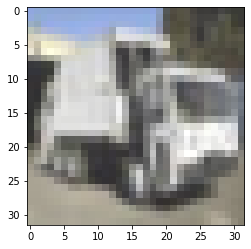

In [23]:
plt.imshow(transposed_data[1115] / 255);

### Цепочка трансофрмаций: преобразование размерностей, приведение значений к диапазону [0, 1] и нормализация.

In [24]:
cifar10_transform = transforms.Compose([
    transforms.Lambda(lambda x: np.reshape(x, (3, 32, 32)).transpose([1, 2, 0])),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.2435, 0.2616))
])

In [25]:
cifar10_transform(reshaped_data[0]).shape

torch.Size([3, 32, 32])

### Создадим объекты для загрузки тренировочных и тестовых данных из нашего набора.

In [26]:
cifar5_h5_train_dataset = HDF5_Dataset('cifar_10.hdf5', train=True, transform=cifar10_transform)

In [27]:
train_dataloader = DataLoader(dataset=cifar5_h5_train_dataset, batch_size=250, shuffle=True)

In [28]:
cifar5_h5_test_dataset = HDF5_Dataset('cifar_10.hdf5', train=False, transform=cifar10_transform)

In [29]:
test_dataloader = DataLoader(dataset=cifar5_h5_test_dataset, batch_size=250, shuffle=True)

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Обучим свёрточную сеть с использованием полученных наборов данных.

In [31]:
class CNN(nn.Module):
    def __init__(self, lr=1e-4, l2=0.):        
        super().__init__()

        self.conv_layer = nn.Sequential(

            # block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3), # 32x30x30
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3), # 128x28x28
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128x14x14

            # block 2
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3), # 256x12x12
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3), # 256x10x10
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) # 256x5x5
        )
        
        self.flat = nn.Flatten() # 256*25 = 6400

        self.fc_layer = nn.Sequential(
            nn.Linear(6400, 3200),
            nn.ReLU(inplace=True),
            nn.Linear(3200, 800),
            nn.ReLU(inplace=True),
            nn.Linear(800, 10)
        )
        
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)  


    def forward(self, x):
        x = self.conv_layer(x) # 256x5x5        
        x = self.flat(x) # 6400        
        x = self.fc_layer(x) # 10        
        x = F.log_softmax(x, dim=1) # 10        
        return x

    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss    

In [32]:
def train_classifier(epoch, model, loader, log=None):
    train_size = len(loader.sampler)
    correct = 0
    for batch_idx, (data, target) in enumerate(loader):        
        model.optim.zero_grad()
        output = model(data)
        loss = model.loss(output, target)
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        loss.backward()
        model.optim.step()
            
        if batch_idx % 100 == 0:
            line = f'Train epoch {epoch} [{batch_idx * len(data):05d}/{train_size}] '
            loss = f'\tloss: {model._loss.item():.6f}'
            print(line + loss)
            
    else:
        batch_idx += 1
        line = f'Train epoch {epoch} [{batch_idx * len(data):05d}/{train_size}] '
        loss = f'\tloss: {model._loss.item():.6f}'
        if log is not None:
            log.append(model._loss)
        print(line + loss)

    train_accuracy = float(correct) / len(loader.dataset)
    line = f'\tTrain accuracy: {train_accuracy}'    
    print(line)

In [33]:
def test_classifier(model, loader, log=None):
    
    avg_lambda = lambda l: f'loss: {l:.4f}'
    acc_lambda = lambda c, p: f'accuracy: {c}/{len(loader.dataset)} ({p:.0f}%)'
    line = lambda l, c, p: avg_lambda(l) + '\t' + acc_lambda(c, p)
    
    test_loss = 0
    correct = 0
    test_size = len(loader.sampler)
    with torch.no_grad():
        for data, target in loader:
            output = model(data)            
            test_loss += model.loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum()                
    
    test_loss /= len(loader.dataset)
    test_accuracy = float(correct) / len(loader.dataset)
    line = line(test_loss, correct, test_accuracy*100)
    report = '\tTest set:' + line
    print(report,'\n')

In [34]:
cnn_cifar_classifier = CNN()
train_log = []
test_log = []

In [36]:
for epoch in range(1, 11):
    cnn_cifar_classifier.train()
    train_classifier(epoch, cnn_cifar_classifier, train_dataloader, log=train_log)
    cnn_cifar_classifier.eval()
    test_classifier(cnn_cifar_classifier, test_dataloader, log=test_log)

Train epoch 1 [00000/50000] 	loss: 2.155929
Train epoch 1 [25000/50000] 	loss: 1.303649
Train epoch 1 [50000/50000] 	loss: 1.118451
	Train accuracy: 0.50272
	Test set:loss: 1.0924	accuracy: 6083/10000 (61%) 

Train epoch 2 [00000/50000] 	loss: 1.074768
Train epoch 2 [25000/50000] 	loss: 0.941617
Train epoch 2 [50000/50000] 	loss: 0.727696
	Train accuracy: 0.65774
	Test set:loss: 0.9143	accuracy: 6781/10000 (68%) 

Train epoch 3 [00000/50000] 	loss: 0.835358
Train epoch 3 [25000/50000] 	loss: 0.749201
Train epoch 3 [50000/50000] 	loss: 0.731529
	Train accuracy: 0.7255
	Test set:loss: 0.8299	accuracy: 7134/10000 (71%) 

Train epoch 4 [00000/50000] 	loss: 0.678310
Train epoch 4 [25000/50000] 	loss: 0.568471
Train epoch 4 [50000/50000] 	loss: 0.659380
	Train accuracy: 0.78254
	Test set:loss: 0.7344	accuracy: 7415/10000 (74%) 

Train epoch 5 [00000/50000] 	loss: 0.427943
Train epoch 5 [25000/50000] 	loss: 0.482206
Train epoch 5 [50000/50000] 	loss: 0.447646
	Train accuracy: 0.83094
	Test se

### Данные преобразуются корректно, сеть обучается.